iteration: 23 obstacle nearby!!
Path found!
[[156.06688752812144, 95.21462368806458], [146.95234603417572, 92.54722685345465], [142.71676393522813, 89.89019010491789], [133.49496372350816, 88.44604336929959], [128.2774689131197, 82.65441812249864], [120.68703424181743, 80.695539575094], [119.71728785675886, 78.35622131197401], [111.47995659031234, 72.69574745704782], [106.04560531256946, 66.37162605688744], [101.1695829132095, 61.48276249756786], [91.61303186895186, 60.33372036920535], [82.16042441875177, 60.529809993881614], [77.74006751809455, 62.866569474618146], [69.53793538787451, 66.63553559747847], [61.771379800469376, 69.00807349489672], [56.797386083255326, 69.51737350580888], [48.76283228862767, 71.67532613450061], [43.059134152858704, 73.9589085969059], [38.097353640807455, 74.57594518433683], [32.53689697389277, 81.01677316581349], [33.421384463972345, 85.9379195647629], [24.36559587770845, 89.5790874419603], [23.006855912307692, 94.24009376163852], [18.20289617818349, 101.

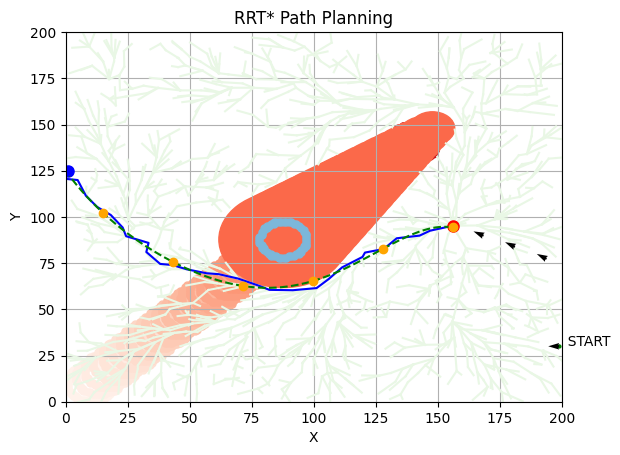

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0.0

class RRTStar:
    def __init__(self, start, goal, obstacle_list, x_limit, y_limit, step_size=1.0, max_iterations=1000):
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.obstacle_list = obstacle_list
        self.x_limit = x_limit
        self.y_limit = y_limit
        self.step_size = step_size
        self.max_iterations = max_iterations
        self.node_list = [self.start]

    def generate_random_node(self):
        x = np.random.uniform(self.x_limit[0], self.x_limit[1])
        y = np.random.uniform(self.y_limit[0], self.y_limit[1])
        return Node(x, y)

    def find_nearest_node(self, node):
        distances = [(n.x - node.x) ** 2 + (n.y - node.y) ** 2 for n in self.node_list]
        nearest_index = np.argmin(distances)
        return self.node_list[nearest_index]

    def is_collision_free(self, node):
        for obstacle in self.obstacle_list:
            if (node.x - obstacle[0]) ** 2 + (node.y - obstacle[1]) ** 2 <= obstacle[2] ** 2:
                return False
        return True

    def steer(self, from_node, to_node):
        angle = np.arctan2(to_node.y - from_node.y, to_node.x - from_node.x)
        new_x = from_node.x + self.step_size * np.cos(angle)
        new_y = from_node.y + self.step_size * np.sin(angle)
        return Node(new_x, new_y)

    def calculate_cost(self, from_node, to_node):
        return from_node.cost + np.sqrt((to_node.x - from_node.x) ** 2 + (to_node.y - from_node.y) ** 2)

    def is_goal_reachable(self, node):
        return np.sqrt((node.x - self.goal.x) ** 2 + (node.y - self.goal.y) ** 2) <= self.step_size

    def rewire(self, new_node):
        for node in self.node_list:
            if node != new_node and np.sqrt((node.x - new_node.x) ** 2 + (node.y - new_node.y) ** 2) <= self.step_size:
                new_cost = self.calculate_cost(new_node, node)
                if new_cost < node.cost:
                    node.parent = new_node
                    node.cost = new_cost

    def bspline_interpolation(self, path, degree=3, num_points=100):
        # Remove duplicate points from the path to ensure strictly increasing x values
        unique_path = np.unique(path, axis=0)

        x = unique_path[:, 0]
        y = unique_path[:, 1]
        tck = make_interp_spline(x, y, k=degree)
        spline = lambda xi: np.array([tck(xi), tck(xi, 1)])
        x_new = np.linspace(min(x), max(x), num_points)
        y_new = spline(x_new)
        return x_new, y_new

    def find_path(self):
        for iteration in range(self.max_iterations):
            random_node = self.generate_random_node()
            nearest_node = self.find_nearest_node(random_node)
            new_node = self.steer(nearest_node, random_node)

            if self.is_collision_free(new_node):
                near_nodes = [node for node in self.node_list if np.sqrt((node.x - new_node.x) ** 2 + (node.y - new_node.y) ** 2) <= 2 * self.step_size]
                min_cost_node = nearest_node
                min_cost = self.calculate_cost(nearest_node, new_node)

                for near_node in near_nodes:
                    if near_node.cost + np.sqrt((near_node.x - new_node.x) ** 2 + (near_node.y - new_node.y) ** 2) < min_cost:
                        min_cost_node = near_node
                        min_cost = near_node.cost + np.sqrt((near_node.x - new_node.x) ** 2 + (near_node.y - new_node.y) ** 2)

                new_node.parent = min_cost_node
                new_node.cost = min_cost
                self.node_list.append(new_node)
                self.rewire(new_node)

                if self.is_goal_reachable(new_node):
                    goal_node = Node(self.goal.x, self.goal.y)
                    goal_node.parent = new_node
                    goal_node.cost = new_node.cost + np.sqrt((new_node.x - self.goal.x) ** 2 + (new_node.y - self.goal.y) ** 2)
                    self.node_list.append(goal_node)
                    return self.extract_path(goal_node)

        return None

    def extract_path(self, goal_node):
        path = [[goal_node.x, goal_node.y]]
        current_node = goal_node

        while current_node.parent is not None:
            current_node = current_node.parent
            path.append([current_node.x, current_node.y])

        return path[::-1]

    def plot(self, path=None):
        for obstacle in self.obstacle_list:
            circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color=plt.cm.Reds(0.5))
            plt.gca().add_patch(circle)
        for node in self.node_list:
            if node.parent is not None:
                plt.plot([node.x, node.parent.x], [node.y, node.parent.y], '-', color=plt.cm.Greens(0.1))
        if path is not None:
            plt.plot([x for x, y in path], [y for x, y in path], '-b')
        plt.plot(self.start.x, self.start.y, 'ro', markersize=8)
        plt.plot(self.goal.x, self.goal.y, 'bo', markersize=8)
        plt.xlim(self.x_limit)
        plt.ylim(self.y_limit)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('RRT* Path Planning')
        plt.grid(True)
        # plt.show()

# def bspline_interpolation(path, degree=3, num_points=100):
#     x = np.array([point[0] for point in path])
#     y = np.array([point[1] for point in path])
#     # Sort x and y based on the values of x
#     sorted_indices = np.argsort(x)
#     x_sorted = x[sorted_indices]
#     y_sorted = y[sorted_indices]

#     tck = make_interp_spline(x_sorted, y_sorted, k=degree)
#     spline = lambda xi: np.array([tck(xi), tck(xi, 1)])
#     x_new = np.linspace(min(x), max(x), num_points)
#     y_new = spline(x_new)
#     return x_new, y_new

# def drawCoodinate(size, ax):
#     x = np.linspace(0,size-1,size)
#     y = np.linspace(0,size-1,size)
#     u = np.zeros((size,size))
#     v = np.zeros((size,size))
#     plt.axis('equal')
#     ax.quiver(x, y, u, v, scale=1, units='xy')

# # Creates axes of plot referenced 'ax'
# ax = plt.axes()
size = 150
# # drawCoodinate(size, ax)
# # plt.xlim(0, size)
# # plt.ylim(0, size)

iteration = 0
iteration_since_see = 1

x_range = 50
y_range = 50

initial_position = [10., 10., np.pi/4]
current_obstacle_position = initial_position
obstacle_old_position = [0., 0.]
dodge_slope = -(current_obstacle_position[2])**(-1)
obstacle_velocity = 5.
obstacle_radius = 10.    # (R)
obstacle_x_velo = obstacle_velocity* np.cos(current_obstacle_position[2])
obstacle_y_velo = obstacle_velocity* np.sin(current_obstacle_position[2])

robot_radius = 17.    # cm (r)
initial_robot_position = [199., 30., np.pi]    # [x, y, theta]
current_robot_position = initial_robot_position
robot_velocity = 0.
robot_omega = 0.
original_robot_velo = robot_velocity
original_robot_omega = robot_omega
robot_x_velo = robot_velocity* np.cos(current_robot_position[2])
robot_y_velo = robot_velocity* np.sin(current_robot_position[2])
see_obstacle = 0

temp_target = [0., 0., 0.]
target = [1., 125., np.pi]
diff_arr = [0., 0., 0.]
controller_index = 0

sampling_freq = 1.    # Hz
safety_margin = 3*robot_radius

turn = 0
nearby = 0

# RRT* parameters
start = (0., 0.)
goal = (0., 0.)
obstacle_list = []  # Format: (x, y, radius), the position after robot see it
x_limit = (0., 200.)
y_limit = (0., 200.)
step_size = 5.0
max_iterations = 3000
# RRT* parameters

def calculate_slope(data):
    slopes = []
    for i in range(1, len(data)):
        x_diff = data[i][0] - data[i - 1][0]
        y_diff = data[i][1] - data[i - 1][1]
        slope = y_diff / x_diff
        slopes.append(slope)
    return slopes

def crossing(x, y, iteration, colorcode, zorder_index):
    if colorcode == 1:
        plt.plot(x, y, marker='o', markersize=5, color=plt.cm.Reds((iteration+1)/50), zorder=zorder_index)
    elif colorcode == 2:
        plt.plot(x, y, marker='o', markersize=5, color=plt.cm.Greens((iteration+1)/50), zorder=zorder_index)
    elif colorcode == 3:
        plt.plot(x, y, marker='o', markersize=5, color=plt.cm.Blues((iteration+1)/50), zorder=zorder_index)

def controller(diff_x, diff_y, diff_theta, iteration, initial_velocity, initial_omega):
    global robot_velocity, robot_omega, current_robot_position, robot_x_velo, robot_y_velo
    k1 = (1100e-4)      # speed
    k2 = (5*k1)      # trajectory

    z1 = diff_theta
    z2 = diff_x*np.cos(diff_theta) + diff_y*np.sin(diff_theta)
    z3 = diff_x*np.sin(diff_theta) - diff_y*np.cos(diff_theta)
    
    x1 = z1
    x2 = z2
    x3 = -2*z3+z1*z2

    denominator = x1**2+x2**2
    u1 = -k1*x1 + ((k2*x3)/denominator)*x2
    u2 = -k1*x2 - ((k2*x3)/denominator)*x1
    
    # robot_omega = u1
    # robot_velocity = 1*(u2 + z3*u1)   # the linear velocoty of the robot
    # get start from zero velocity
    initial_region = 30
    if iteration <= initial_region:
        robot_velocity = (iteration*((iteration+1)/(initial_region*1.1))*(u2 + z3*u1) + (initial_region-iteration)*initial_velocity)/initial_region
        robot_omega = (iteration*((iteration+0.1*initial_region)/(initial_region*1.1))*u1 + (initial_region-iteration)*initial_omega)/initial_region
    else:
        robot_velocity = 1*(u2 + z3*u1)   # the linear velocoty of the robot
        robot_omega = 1*u1
    robot_x_velo = -robot_velocity* np.cos(current_robot_position[2])      # the negative sign should be modified
    robot_y_velo = -robot_velocity* np.sin(current_robot_position[2])      # the negative sign should be modified

# plotting trajectory
while (0<current_obstacle_position[0] and current_obstacle_position[0]<size and 0<current_obstacle_position[1] and current_obstacle_position[1]<size 
       or 0<current_robot_position[0] and current_robot_position[0]<size and 0<current_robot_position[1] and current_robot_position[1]<size):
    # plot the starting point
    if iteration == 0:
        plt.quiver(current_robot_position[0], current_robot_position[1], 
                   np.cos(current_robot_position[2]), np.sin(current_robot_position[2]),
                     scale=1, units='xy')
        plt.plot(current_robot_position[0], current_robot_position[1], marker="o", markersize=2, markeredgecolor="green", markerfacecolor="green")
        plt.text(current_robot_position[0], current_robot_position[1], '  START', zorder = 3)

    # check if robot near the obstacle
    if np.sqrt((current_obstacle_position[0]-current_robot_position[0])**2+
               (current_obstacle_position[1]-current_robot_position[1])**2
               ) <= obstacle_radius+robot_radius+safety_margin and turn == 0:
        print("iteration:", iteration+1, "obstacle nearby!!")
        nearby = 1
        see_obstacle = 1
        # get the trajectory of obstacle through robot
        # the formula of the trajectory: y=ax+b
        a = np.tan(current_obstacle_position[2])
        b = current_obstacle_position[1] - np.tan(current_obstacle_position[2])*current_obstacle_position[0]

        # determine the temporary distination robot should go
        # if (a*current_robot_position[0]-current_robot_position[1]+b > 0): # if the robot right to trajectory, ### Robot go RIGHT ###
        #     temp_target[0] = current_obstacle_position[0] + (obstacle_radius+robot_radius)*np.cos(np.pi/2-current_obstacle_position[2])
        #     temp_target[1] = current_obstacle_position[1] - (obstacle_radius+robot_radius)*np.sin(np.pi/2-current_obstacle_position[2])
        # else:                                                             # if the robot left to trajectory, ### Robot go LEFT ###
        #     temp_target[0] = current_obstacle_position[0] - (obstacle_radius+robot_radius)*np.cos(np.pi/2-current_obstacle_position[2])
        #     temp_target[1] = current_obstacle_position[1] + (obstacle_radius+robot_radius)*np.sin(np.pi/2-current_obstacle_position[2])
        # temp_target[2] = current_robot_position[2]

        # RRT*
        start = (current_robot_position[0], current_robot_position[1])
        goal = (target[0], target[1])        
        # RRT*
        
        # plt.plot(temp_target[0], temp_target[1], marker='x', markersize=10, color = 'g')
        # print(temp_target)
        controller_index = 0
        turn = 1      
    else:
        # controller to distination
        for j in range(3):
            diff_arr[j] = current_robot_position[j] - target[j]
        controller(diff_arr[0], diff_arr[1], diff_arr[2], controller_index, robot_velocity, robot_omega)  
        controller_index += 1  

    # calculate the difference
    # if turn == 1:
    #     # break
    #     for j in range(3):
    #         diff_arr[j] = current_robot_position[j] - temp_target[j]
    #     controller(diff_arr[0], diff_arr[1], diff_arr[2], controller_index) 
    #     controller_index += 1  
    #     # print(robot_x_velo, robot_y_velo, robot_omega)   # print for debugging
    #     if np.sqrt((current_robot_position[0]-temp_target[0])**2 + 
    #                (current_robot_position[1]-temp_target[1])**2) < 1.2*robot_radius:  # if robot is close enough to temp. distination, continue
    #         turn = 0
    #         controller_index = 0

    # plot the current status (arrow)
    if not turn:
        plt.quiver(current_robot_position[0], current_robot_position[1],
                    1*np.cos(current_robot_position[2]), 1*np.sin(current_robot_position[2]),
                    scale=0.2, units='xy', zorder = 3)

    if see_obstacle:
        # make the radius of the obstacle smaller and smaller
        if (obstacle_radius+robot_radius)-1*iteration_since_see > 5:
            width = (obstacle_radius+robot_radius)-1*iteration_since_see
        else:
            width = 5
        obstacle_list.append([current_obstacle_position[0], current_obstacle_position[1], width])
        iteration_since_see += 1


    # plot the area for obstacle and robot
    for x in range(size):
        for y in range(size):
            if (np.sqrt((current_obstacle_position[0]-x)**2 + (current_obstacle_position[1]-y)**2) <= obstacle_radius
                and np.sqrt((current_obstacle_position[0]-x)**2 + (current_obstacle_position[1]-y)**2) >= obstacle_radius - 1) and not nearby:
                crossing(x, y, iteration, 1, 1)
            elif (np.sqrt((current_obstacle_position[0]-x)**2 + (current_obstacle_position[1]-y)**2) <= obstacle_radius
                and np.sqrt((current_obstacle_position[0]-x)**2 + (current_obstacle_position[1]-y)**2) >= obstacle_radius - 1) and nearby:
                crossing(x, y, iteration, 3, 4)
    
            # if (np.sqrt((current_robot_position[0]-x)**2 + (current_robot_position[1]-y)**2) <= robot_radius
            #     and np.sqrt((current_robot_position[0]-x)**2 + (current_robot_position[1]-y)**2) >= robot_radius - 1) and not nearby:
            #     crossing(x, y, iteration, 2, 2)
            # elif (np.sqrt((current_robot_position[0]-x)**2 + (current_robot_position[1]-y)**2) <= robot_radius
            #     and np.sqrt((current_robot_position[0]-x)**2 + (current_robot_position[1]-y)**2) >= robot_radius - 1) and nearby:
            #     crossing(x, y, iteration, 3, 4)

    nearby = 0
    
    # moving to next position
    current_obstacle_position[0] += obstacle_x_velo*(1/sampling_freq)
    current_obstacle_position[1] += obstacle_y_velo*(1/sampling_freq)
    if not see_obstacle:
        current_robot_position[0] += robot_x_velo*(1/sampling_freq)
        current_robot_position[1] += robot_y_velo*(1/sampling_freq)
        current_robot_position[2] += robot_omega*(1/sampling_freq)
    else:
        robot_velocity = 0.
        robot_omega = 0.

    if iteration == 50:
        break

    iteration += 1

# RRT*
rrt_star = RRTStar(start, goal, obstacle_list, x_limit, y_limit, step_size, max_iterations)
path = rrt_star.find_path()
if path is not None:
    print("Path found!")
    print(path)
    # x_sp, y_sp = rrt_star.bspline_interpolation(path)  # Get the B-spline interpolated curve
    # plt.plot(x_sp, y_sp[1], color='purple')  # Plot the B-spline curve
    rrt_star.plot(path)
else:
    print("Path not found.")

# Create Bezier Curve
# sort x
bazier_points = np.array(path)
sorted_indices = np.argsort(bazier_points[:, 0])
points_sorted = bazier_points[sorted_indices]

# Bezier interpolation
degree = len(bazier_points)/5.  # 设置Bezier曲线的阶数
coefficients = np.polyfit(points_sorted[:, 0], points_sorted[:, 1], degree)

# smooth the path
x_smooth = np.linspace(min(points_sorted[:, 0]), max(points_sorted[:, 0]), 500)
y_smooth = np.polyval(coefficients, x_smooth)
# plt.plot(points_sorted[:, 0], points_sorted[:, 1], 'b', label='Original Data')
plt.plot(x_smooth, y_smooth, 'g--', label='Bezier Curve')
plt.plot(start[0], start[1], 'ro')
plt.plot(goal[0], goal[1], 'bo')
plt.grid(True)

# 先將 x_smooth 和 y_smooth 的數據點反轉
x_smooth_reversed = x_smooth[::-1]
y_smooth_reversed = y_smooth[::-1]
# 使用 zip 函數將 x_smooth_reversed 和 y_smooth_reversed 打包成元組，然後轉換為新的 list
smooth_data = list(zip(x_smooth_reversed, y_smooth_reversed))
smooth_data = [[x, y] for x, y in smooth_data]
smooth_slope = calculate_slope(smooth_data)   # the slope is calculated from right to left
smooth_theta = np.arctan(smooth_slope)+np.pi

##### control for RRT* ####
controller_index = 0
smooth_data_index = 90      # record which point is temporary target
smooth_data_increase = smooth_data_index
for i in range(len(x_smooth_reversed)):
    if i%smooth_data_index == 0:
        plt.plot(x_smooth_reversed[i], y_smooth_reversed[i], marker='o', color='orange')

while(0<current_robot_position[0] and current_robot_position[0]<size and 0<current_robot_position[1] and current_robot_position[1]<size):
    
    print("now smooth data index:", smooth_data_index)
    # print(smooth_data[smooth_data_index], smooth_theta[smooth_data_index])
    # print(smooth_data[smooth_data_index])
    # print(smooth_data[smooth_data_index+10])

    if np.sqrt((current_robot_position[0]-smooth_data[smooth_data_index][0])**2 + 
               (current_robot_position[1]-smooth_data[smooth_data_index][1])**2) <= 10.: # if close enough for some distance
        smooth_data_index += smooth_data_increase   # proceed to the next point
        controller_index = 0
        robot_velocity = 0.
        robot_omega = 0.
    
    # calculate the difference
    for j in range(2):
        diff_arr[j] = current_robot_position[j] - smooth_data[smooth_data_index][j]
    diff_arr[2] = current_robot_position[2] - smooth_theta[smooth_data_index] 
    controller(diff_arr[0], diff_arr[1], diff_arr[2], controller_index, robot_velocity, robot_omega) 
    controller_index += 1  
        
    # plot the current status
    plt.quiver(current_robot_position[0], current_robot_position[1],
            1*np.cos(current_robot_position[2]), 1*np.sin(current_robot_position[2]),
            scale=0.5, units='xy', zorder = 3)

    # moving to next position
    current_robot_position[0] += robot_x_velo*(1/sampling_freq)
    current_robot_position[1] += robot_y_velo*(1/sampling_freq)
    current_robot_position[2] += robot_omega*(1/sampling_freq)

    if np.sqrt((current_robot_position[0]-target[0])**2 + 
               (current_robot_position[1]-target[1])**2) < 1. or smooth_data_index > len(smooth_data):
        break

##### control for RRT* ####


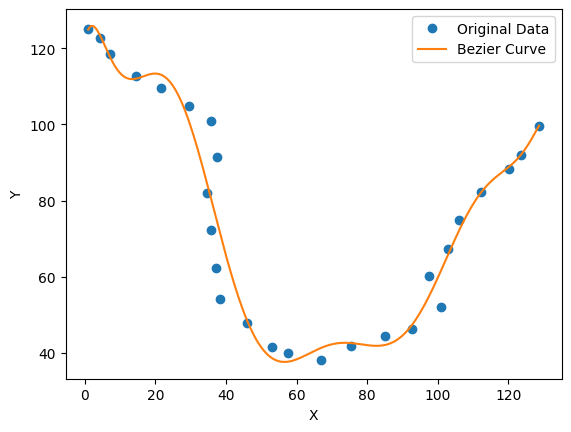

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# 假设points是您提供的数据
points = [[128.71185294056582, 99.68227709911136], [123.44792676860541, 91.99598407678778], [120.05695828120258, 88.32156810721644], [112.31261574767555, 82.29869211721052], [106.03421088746512, 74.7974497148068], [102.77263577043622, 67.20891899184274], [97.5754058223969, 60.205270919419], [100.78450906692659, 52.01720709092049], [92.68466834647477, 46.22905636044738], [85.05237627992304, 44.37911534799964], [75.49637556889306, 41.85780243824217], [66.87605069077173, 38.210484465540546], [57.64755125544297, 39.94897828041466], [52.93753959253581, 41.62700990564659], [46.10069217566468, 47.85653539858317], [38.35772554699927, 54.17841175637476], [37.32885086644126, 62.34461622207063], [35.77707178201147, 72.17970564386302], [34.56448006378463, 82.09693793253777], [37.517531290137654, 91.47672285389156], [35.71925166942346, 100.8132890195035], [29.509531446501807, 104.78216141241825], [21.65228850182213, 109.58401000324311], [14.411341323387168, 112.76393218043562], [7.067490646348056, 118.57771291516814], [4.300033757470409, 122.74198744600825], [1.0, 125.0]]

# 将数据转换为NumPy数组，并按x值进行排序
points = np.array(points)
sorted_indices = np.argsort(points[:, 0])
points_sorted = points[sorted_indices]

# 使用np.polyfit进行Bezier插值
degree = len(points)/2.5  # 设置Bezier曲线的阶数
coefficients = np.polyfit(points_sorted[:, 0], points_sorted[:, 1], degree)

# 生成更平滑的路径
x_smooth = np.linspace(min(points_sorted[:, 0]), max(points_sorted[:, 0]), 500)
y_smooth = np.polyval(coefficients, x_smooth)

# 绘制平滑的路径
plt.plot(points_sorted[:, 0], points_sorted[:, 1], 'o', label='Original Data')
plt.plot(x_smooth, y_smooth, label='Bezier Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


Path found!
[[10, 10], [14.580680327389912, 12.00433723167112], [17.078200486248186, 20.483499919962206], [21.76280341884447, 28.637126488231694], [26.07613397426242, 37.65356815844528], [27.7238179830903, 46.22772247497849], [31.202404400894228, 49.81930103236382], [35.775724239707635, 55.942539754333126], [43.52094333985621, 58.842560262895915], [52.025578765701006, 62.994802020131225], [57.01003710033571, 63.38872474134781], [63.66298219444503, 69.98290957667102], [72.54345166817852, 72.1797488878845], [79.2036219968096, 76.6320625386537], [81.45740013138801, 80.8762417364772], [86.73304915716035, 87.78347527944705], [90, 90]]


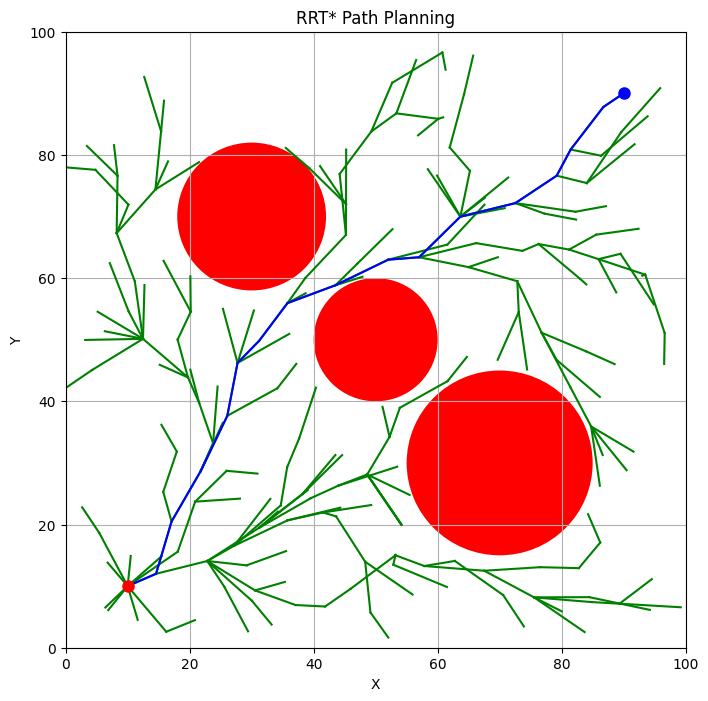

In [164]:
import numpy as np
import matplotlib.pyplot as plt

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0.0

class RRTStar:
    def __init__(self, start, goal, obstacle_list, x_limit, y_limit, step_size=1.0, max_iterations=1000):
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.obstacle_list = obstacle_list
        self.x_limit = x_limit
        self.y_limit = y_limit
        self.step_size = step_size
        self.max_iterations = max_iterations
        self.node_list = [self.start]

    def generate_random_node(self):
        x = np.random.uniform(self.x_limit[0], self.x_limit[1])
        y = np.random.uniform(self.y_limit[0], self.y_limit[1])
        return Node(x, y)

    def find_nearest_node(self, node):
        distances = [(n.x - node.x) ** 2 + (n.y - node.y) ** 2 for n in self.node_list]
        nearest_index = np.argmin(distances)
        return self.node_list[nearest_index]

    def is_collision_free(self, node):
        for obstacle in self.obstacle_list:
            if (node.x - obstacle[0]) ** 2 + (node.y - obstacle[1]) ** 2 <= obstacle[2] ** 2:
                return False
        return True

    def steer(self, from_node, to_node):
        angle = np.arctan2(to_node.y - from_node.y, to_node.x - from_node.x)
        new_x = from_node.x + self.step_size * np.cos(angle)
        new_y = from_node.y + self.step_size * np.sin(angle)
        return Node(new_x, new_y)

    def calculate_cost(self, from_node, to_node):
        return from_node.cost + np.sqrt((to_node.x - from_node.x) ** 2 + (to_node.y - from_node.y) ** 2)

    def is_goal_reachable(self, node):
        return np.sqrt((node.x - self.goal.x) ** 2 + (node.y - self.goal.y) ** 2) <= self.step_size

    def rewire(self, new_node):
        for node in self.node_list:
            if node != new_node and np.sqrt((node.x - new_node.x) ** 2 + (node.y - new_node.y) ** 2) <= self.step_size:
                new_cost = self.calculate_cost(new_node, node)
                if new_cost < node.cost:
                    node.parent = new_node
                    node.cost = new_cost

    def find_path(self):
        for iteration in range(self.max_iterations):
            random_node = self.generate_random_node()
            nearest_node = self.find_nearest_node(random_node)
            new_node = self.steer(nearest_node, random_node)

            if self.is_collision_free(new_node):
                near_nodes = [node for node in self.node_list if np.sqrt((node.x - new_node.x) ** 2 + (node.y - new_node.y) ** 2) <= 2 * self.step_size]
                min_cost_node = nearest_node
                min_cost = self.calculate_cost(nearest_node, new_node)

                for near_node in near_nodes:
                    if near_node.cost + np.sqrt((near_node.x - new_node.x) ** 2 + (near_node.y - new_node.y) ** 2) < min_cost:
                        min_cost_node = near_node
                        min_cost = near_node.cost + np.sqrt((near_node.x - new_node.x) ** 2 + (near_node.y - new_node.y) ** 2)

                new_node.parent = min_cost_node
                new_node.cost = min_cost
                self.node_list.append(new_node)
                self.rewire(new_node)

                if self.is_goal_reachable(new_node):
                    goal_node = Node(self.goal.x, self.goal.y)
                    goal_node.parent = new_node
                    goal_node.cost = new_node.cost + np.sqrt((new_node.x - self.goal.x) ** 2 + (new_node.y - self.goal.y) ** 2)
                    self.node_list.append(goal_node)
                    return self.extract_path(goal_node)

        return None

    def extract_path(self, goal_node):
        path = [[goal_node.x, goal_node.y]]
        current_node = goal_node

        while current_node.parent is not None:
            current_node = current_node.parent
            path.append([current_node.x, current_node.y])

        return path[::-1]

    def plot(self, path=None):
        plt.figure(figsize=(8, 8))
        for obstacle in self.obstacle_list:
            circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], fc='r')
            plt.gca().add_patch(circle)
        for node in self.node_list:
            if node.parent is not None:
                plt.plot([node.x, node.parent.x], [node.y, node.parent.y], '-g')
        if path is not None:
            plt.plot([x for x, y in path], [y for x, y in path], '-b')
        plt.plot(self.start.x, self.start.y, 'ro', markersize=8)
        plt.plot(self.goal.x, self.goal.y, 'bo', markersize=8)
        plt.xlim(self.x_limit)
        plt.ylim(self.y_limit)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('RRT* Path Planning')
        plt.grid(True)
        plt.show()

# Example usage
start = (10, 10)
goal = (90, 90)
obstacle_list = [(50, 50, 10), (70, 30, 15), (30, 70, 12)]  # Format: (x, y, radius)
x_limit = (0, 100)
y_limit = (0, 100)
step_size = 5.0
max_iterations = 1000

rrt_star = RRTStar(start, goal, obstacle_list, x_limit, y_limit, step_size, max_iterations)
path = rrt_star.find_path()

if path is not None:
    print("Path found!")
    print(path)
    rrt_star.plot(path)
else:
    print("Path not found.")
